In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import torch.nn as nn
import torchvision
from torch import optim, cuda
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader ,sampler
import matplotlib.pyplot as plt
import os
import time
import cv2
import copy
from IPython.core.interactiveshell import InteractiveShell
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer
# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'


In [2]:
'''
functions in datahandler 
def process_image(image_path):
def imshow_tensor(image, ax=None, title=None):
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,max_epochs_stop=3,n_epochs=20,print_every=2):
def display_prediction(image_path, model, topk):
def predict(image_path, model, topk=5):
def save_checkpoint(model, path,history):

make sure train_on_gpu true if training in GPU
else false;
'''

'\nfunctions in datahandler \ndef process_image(image_path):\ndef imshow_tensor(image, ax=None, title=None):\ndef train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,max_epochs_stop=3,n_epochs=20,print_every=2):\ndef display_prediction(image_path, model, topk):\ndef predict(image_path, model, topk=5):\ndef save_checkpoint(model, path,history):\n\nmake sure train_on_gpu true if training in GPU\nelse false;\n'

In [3]:
'''
functions in getmethod files  
    def get_pretrained_model(model_name):
    def evaluate(model, test_loader, criterion, topk=[1]):
    def imshow(image):
make sure train_on_gpu true if training in GPU
else false;
'''

'\nfunctions in getmethod files  \n    def get_pretrained_model(model_name):\n    def evaluate(model, test_loader, criterion, topk=[1]):\n    def imshow(image):\nmake sure train_on_gpu true if training in GPU\nelse false;\n'

In [4]:
src='C:\\Users\\Harshit\\Desktop\\MTP\\training_folder'
traindir = os.path.join(src,'train')
validdir = os.path.join(src,'val')
testdir = os.path.join(src,'test')
save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

# Change to fit hardware
batch_size = 16
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False


Train on gpu: True
1 gpus detected.


In [37]:
%run datahandler
%run get_method

1 gpus detected.
1 gpus detected.


<Figure size 432x288 with 0 Axes>

In [6]:
batch_size=16
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data = {
    'train':
    datasets.ImageFolder(root=os.path.join(src,'train'), transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=os.path.join(src,'val'), transform=image_transforms['valid']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [7]:
# Iterate through the dataloader once
trainiter=iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape,labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

# training


In [8]:
torch.cuda.empty_cache()

In [9]:
n_classes=2
model = models.vgg16(pretrained=True)
# Freeze model weights
for parm in model.parameters():
    parm.requires_grad=False
n_inputs = model.classifier[6].in_features
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, n_classes)]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier

model = model.to('cuda')
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

134,268,738 total parameters.
8,194 training parameters.


In [67]:
model2=models.vgg16(pretrained=True)

In [68]:
model2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [69]:
model2.classifier=nn.Sequential(*list(model.classifier.children())[:-1])

In [70]:
model2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [66]:
features

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False)]

In [10]:
for name,parm in model.named_parameters():
    if (parm.requires_grad==True) :
        name

'classifier.6.weight'

'classifier.6.bias'

In [11]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'Negative'), (1, 'Positive')]

In [12]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters())
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

134,268,738 total parameters.
8,194 training parameters.


In [14]:
train_on_gpu = torch.cuda.is_available()
model, history1 = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=10,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 766.11 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.0611 	Validation Loss: 0.0157
		Training Accuracy: 98.02%	 Validation Accuracy: 99.45%
Epoch: 3	100.00% complete. 745.98 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.0609 	Validation Loss: 0.0133
		Training Accuracy: 98.08%	 Validation Accuracy: 99.52%
Epoch: 5	100.00% complete. 737.25 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.0594 	Validation Loss: 0.0128
		Training Accuracy: 98.23%	 Validation Accuracy: 99.58%
Epoch: 7	100.00% complete. 725.65 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.0585 	Validation Loss: 0.0230
		Training Accuracy: 98.28%	 Validation Accuracy: 99.23%
Epoch: 9	100.00% complete. 716.56 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.0667 	Validation Loss: 0.0227
		Training Accuracy: 98.11%	 Validation Accuracy: 99.27%

Best epoch: 8 with loss: 0.01 and acc: 99.27%
8750.22 total seconds elapsed. 972.25 seconds per 

In [15]:
save_checkpoint(model, checkpoint_path,model.optimizer,history1)

# loading saved model

In [ ]:
model,optimizer,history=load_checkpoint(checkpoint_path)

In [22]:
cat_df=pd.read_csv('cat_df')

In [18]:
history=history1

# training results

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

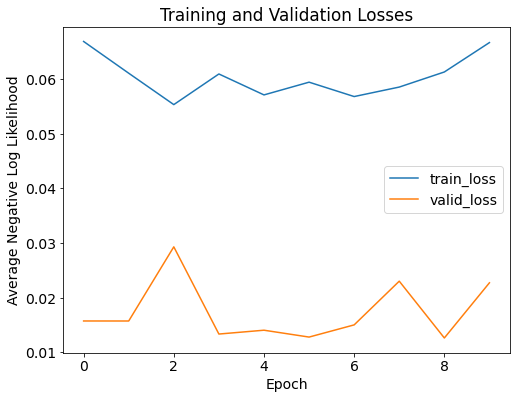

In [19]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

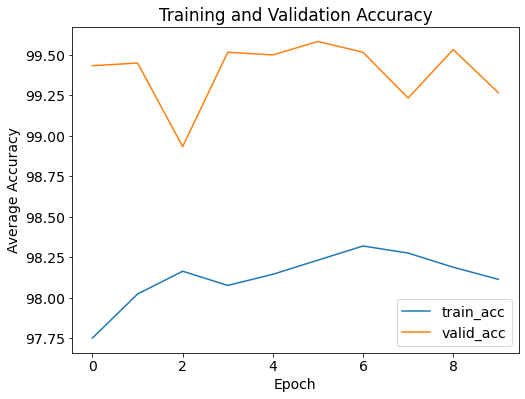

In [20]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')


# inference

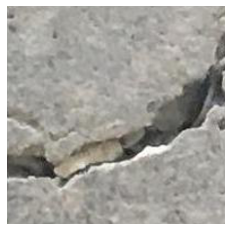

In [31]:
np.random.seed = 100
%matplotlib inline
def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = os.path.join(testdir,c)
    img_path = os.path.join(root,np.random.choice(os.listdir(root)))
    return img_path

p=random_test_image()
_ = imshow_tensor(process_image(p))


torch.Size([3, 224, 224])

Negative
[8.8279376e+02 1.3359782e-03]


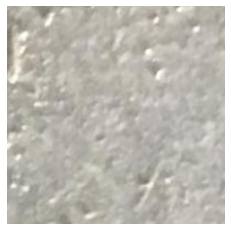

In [33]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
img.shape
ax,image=imshow_tensor(img)
print(real_class)
print(top_p)
plt.imshow(image)


In [73]:
mod = nn.Sequential(*list(model.children())[:-1])

In [75]:
mod

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model(features.to('cuda')), targets,topk=[1])
else:
    accuracy(model(features), targets,topk=[1])

[100.0]

In [43]:
features

tensor([[[[ 0.8447,  0.8276,  0.9132,  ...,  1.0331,  1.0673,  1.1015],
          [ 0.8961,  0.8789,  0.8618,  ...,  1.0159,  1.0502,  1.0673],
          [ 0.9646,  0.9646,  0.9132,  ...,  0.9646,  0.9988,  1.0331],
          ...,
          [ 1.1015,  1.1015,  1.0159,  ...,  0.9303,  0.9474,  0.9474],
          [ 1.0502,  1.0673,  1.0331,  ...,  0.9646,  0.9817,  0.9646],
          [ 0.9988,  1.0502,  1.0331,  ...,  0.9988,  1.0159,  0.9817]],

         [[ 0.7829,  0.7654,  0.8529,  ...,  0.9755,  1.0105,  1.0455],
          [ 0.8354,  0.8179,  0.8004,  ...,  0.9580,  0.9930,  1.0105],
          [ 0.9055,  0.9055,  0.8529,  ...,  0.9055,  0.9405,  0.9755],
          ...,
          [ 1.0805,  1.0805,  0.9930,  ...,  0.9055,  0.9230,  0.9230],
          [ 1.0280,  1.0455,  1.0105,  ...,  0.9405,  0.9580,  0.9405],
          [ 0.9755,  1.0280,  1.0105,  ...,  0.9755,  0.9930,  0.9580]],

         [[ 0.7925,  0.7751,  0.8622,  ...,  0.9842,  1.0191,  1.0539],
          [ 0.8448,  0.8274,  

In [39]:
criterion = nn.CrossEntropyLoss()
results = evaluate(model, dataloaders['test'], criterion)
results.head()

,class,top1,loss
0,Negative,99.4,0.029010
1,Positive,98.5,0.068305


# test code

In [41]:
nb_classes = 2
device='cuda'
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)


tensor([[994.,   6.],
        [ 15., 985.]])


In [1]:
confusion_matrix

NameError: name 'confusion_matrix' is not defined

In [44]:
TP=985
TN=994
FN=15
FP=6


In [45]:
recall=TP/(TP+FN)
precision=TP/(TP+FP)
f1_score=2*recall*precision/(precision+recall)

In [46]:
f1_score

0.9894525364138623

Linear(in_features=4096, out_features=2, bias=True)

In [52]:
model=model.cpu()

In [53]:
params = list(model.classifier[6].parameters())
weight = np.squeeze(params[-1].data.numpy())

In [ ]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
img.shape
ax,image=imshow_tensor(img)
print(real_class)
print(top_p)
plt.imshow(image)


In [58]:
import torch.nn.functional as F
from torch.autograd import Variable

In [76]:
    predicted_labels=[]
    p=random_test_image() 
    img_tensor=process_image(p)
    img_variable = Variable(img_tensor.unsqueeze(0))
    logit = model(img_variable)

    h_x = F.softmax(logit, dim=1).data.squeeze()
    
    probs, idx = h_x.sort(0, True)
    probs = probs.detach().numpy()
    idx = idx.numpy()
    testiter = iter(dataloaders['test'])
    # Get a batch of testing images and labels
    predicted, targets = next(testiter)
    predicted_labels.append(targets)
    #predicted =  train_loader.dataset.classes[idx[0]]
    
    #print("Target: " + targets + " | Predicted: " +  predicted) 
 
    features_blobs = mod(img_variable)
    features_blobs1 = features_blobs.cpu().detach().numpy()
    CAMs = return_CAM(features_blobs1, weight, [idx[0]])

    readImg = org_loc+fname+'.png'
    img = cv2.imread(readImg)
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.5 + img * 0.5
  
    cv2.imwrite("image_1", result)

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [54]:
def return_CAM(feature_conv, weight, class_idx):
    # generate the class -activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight[idx], beforeDot)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [90]:
testiter = iter(dataloaders['test'])
    # Get a batch of testing images and labels
predicted, targets = next(testiter)

In [95]:
predicted.unsqueeze(0).shape

torch.Size([1, 16, 3, 224, 224])

In [98]:
model.cuda()
model.eval()
prediction_var = Variable((predicted.unsqueeze(0)).cuda(), requires_grad=True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

ReLU(inplace=True)

In [102]:
final_layer = model.features[29]
activated_features = SaveFeatures(final_layer)

In [103]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()


In [115]:
prediction_var.sum(dim=0).shape

torch.Size([16, 3, 224, 224])

In [116]:
prediction1 = model(prediction_var.sum(dim=0))
pred_probabilities = F.softmax(prediction1).data.squeeze()
activated_features.remove()

<ipython-input-116-7529e9bac894>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction1).data.squeeze()


In [118]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


In [121]:
weight_softmax_params = list(model.classifier[6].parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())


In [128]:
weight_softmax.shape

(2, 4096)

In [125]:
class_idx=targets

In [126]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

ValueError: cannot reshape array of size 1605632 into shape (512,196)

Text(0.5, 6.800000000000011, 'images')

Text(0.42500000000000426, 0.5, 'Accuracy (%)')

Text(0.5, 1.0, 'Top 1 Accuracy vs Number of Training Images')

(-5.0, 105.0)

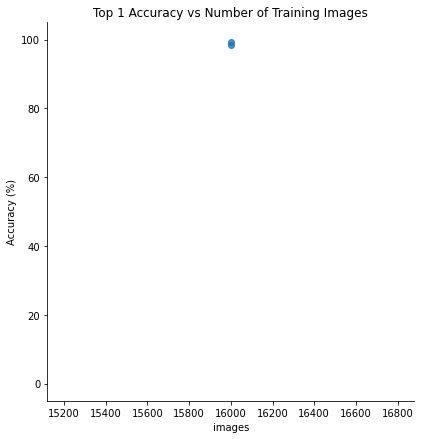

In [47]:
results = results.merge(cat_df, left_on='class', right_on='category').\
drop(columns=['category'])
# Plot using seaborn
sns.lmplot(
    y='top1', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 1 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)
